pip install --force-reinstall tensorflow

# SOMMAIRE

### Introduction

L'objectif de ce projet est d'entrainer un CNN capable de classer les images en fonction de la race du chien présent sur l'image, en utilisant notamment du Transfert Learning.  
Le dataset utilisé est le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) .


1. [Imports et chemins](#-1.-Imports-et-chemins)
2. [Observation des données](#-2.-Observation-des-données)
3. [Preprocessing](#-3.-Preprocessing)
4. [Modèles CNN](#-4.-Modèles-CNN)
5. [Transfer Learning](#-5.-Transfer-Learning)

## 1. Imports et chemins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Observation
from wordcloud import WordCloud

# Preprocessing
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH_INPUT = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/input"
PATH_OUTPUT = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/output"
PATH_FIGURES = "/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/output/figures"

In [3]:
# Unix : Il ne faut pas prendre en compte les fichiers cachés
list_breeds = [f for f in os.listdir(PATH_INPUT + "/Images") if not f.startswith('.')]

## 2. Observation des données

In [4]:
print(f"Nb de catégories/d'espèces de chiens :", len(list_breeds))

Nb de catégories/d'espèces de chiens : 120


In [5]:
# Production d'un df
 
df = pd.DataFrame(list_breeds, columns=['Id_name_breed'])
df['breed_name']=df['Id_name_breed'].apply(lambda x: x.split('-')[1])
df['Id']=df['Id_name_breed'].apply(lambda x: x.split('-')[0])

nb_pic=[]
for name in df.Id_name_breed:
   nb_pic.append(len(os.listdir(f"{PATH_INPUT}//Images" + "/" + name)))

df['nb_pic']=nb_pic

print("Nb total d'images:", df["nb_pic"].sum())

Nb total d'images: 20580


In [6]:
df.head(3)

Id_name_breed                breed_name         Id  \
0             n02097658-silky_terrier             silky_terrier  n02097658   
1        n02092002-Scottish_deerhound        Scottish_deerhound  n02092002   
2  n02099849-Chesapeake_Bay_retriever  Chesapeake_Bay_retriever  n02099849   

   nb_pic  
0     183  
1     232  
2     167

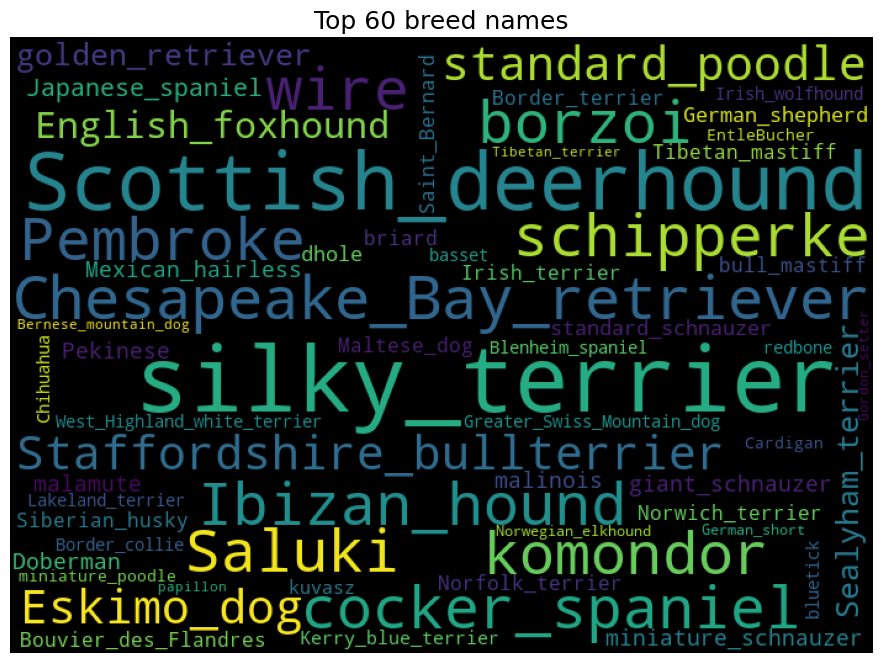

In [7]:
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=60, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(df.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 60 breed names", fontsize=18)
plt.show()

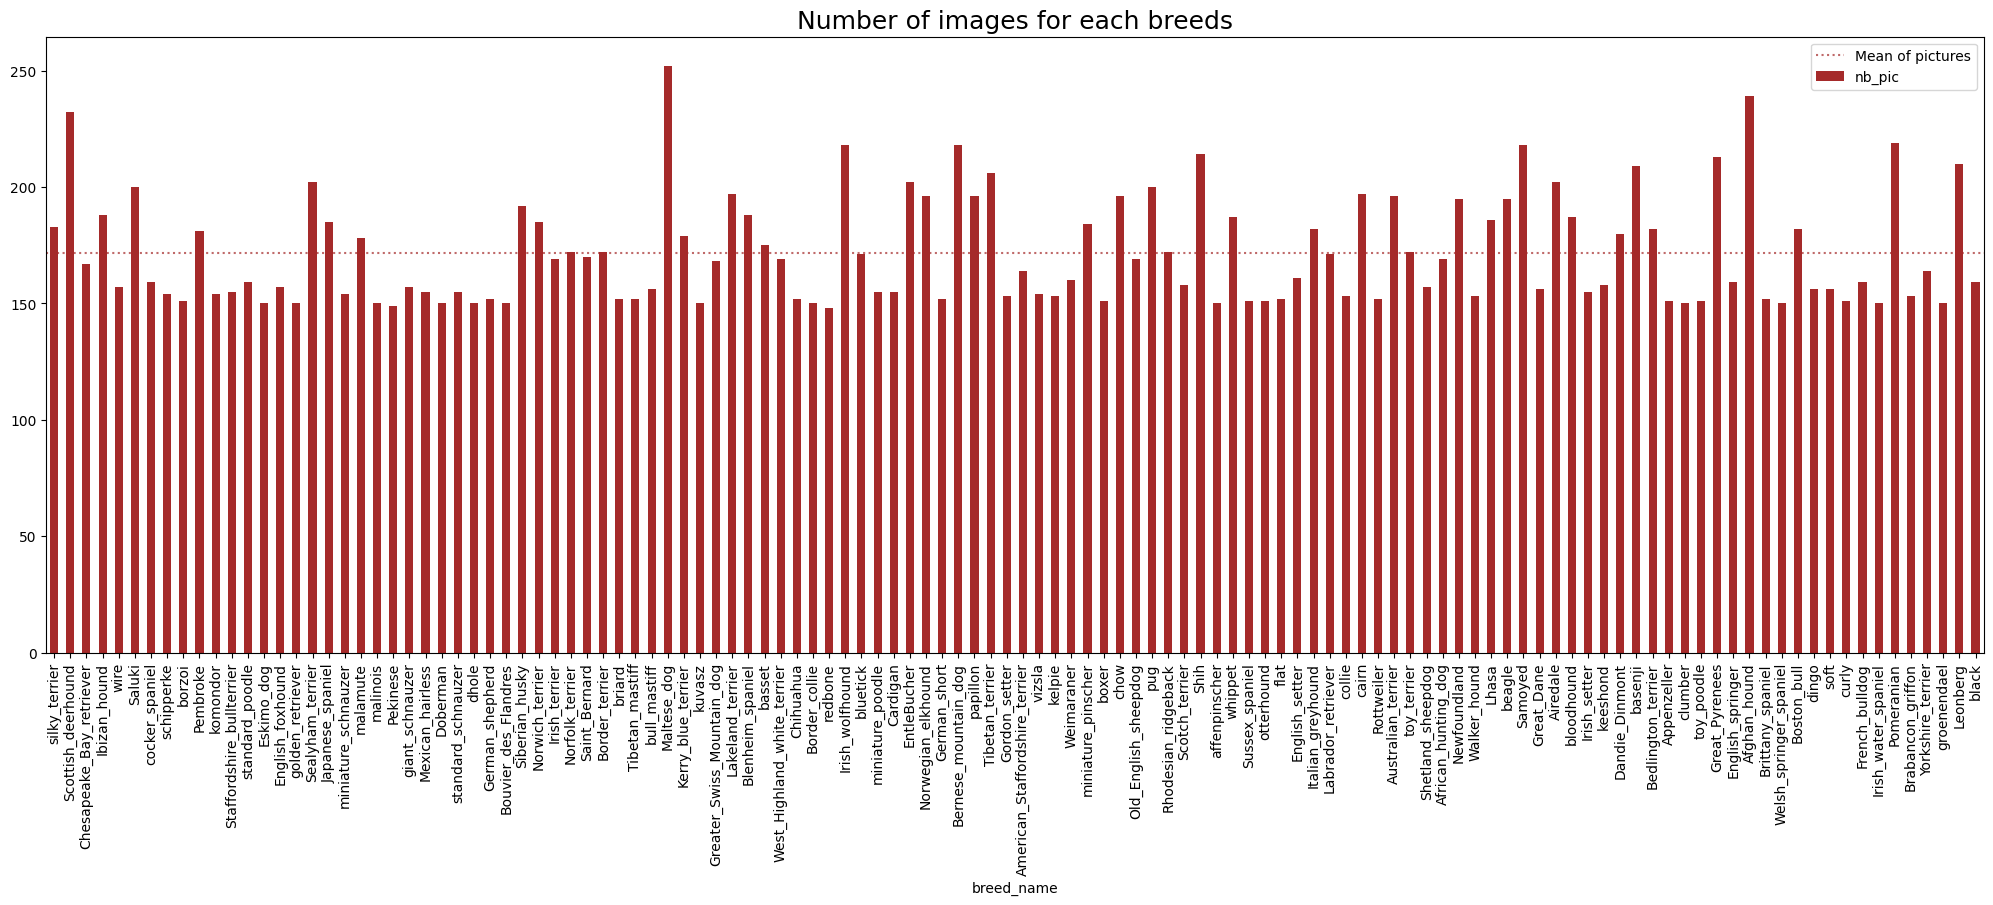

Le nb moyen d'images par classe est de 171.5
Le nb d'images par classe varie entre 148 et 252


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25,8))
df.plot(x='breed_name',kind="bar", color='brown',legend=False,ax=ax)
ax.axhline(df["nb_pic"].mean(),
           color='brown', alpha=.7,
           linestyle=':',
           label="Mean of pictures")
plt.title("Number of images for each breeds",
          color='k', fontsize=18)
plt.legend()
plt.show()

print("Le nb moyen d'images par classe est de", df["nb_pic"].mean())
print("Le nb d'images par classe varie entre", df["nb_pic"].min(), "et", df["nb_pic"].max())

In [9]:
import matplotlib.image as mpimg

In [10]:
#list of directories 
path_list=[]
for classe in df['Id_name_breed'].values:
    images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)
    for i in range(len(images)):
        path_list.append(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        
#list of images shape        
ds_img=[]
for path in path_list:
    ds_img.append(mpimg.imread(path).shape)

#data frame of results    
ds_img = pd.DataFrame(ds_img, index = path_list,columns=['heigth','width','color'])
#list of breed which corespoonds to each path      
y=[]
for j in range(len(list_breeds)):
   for k in range(df.nb_pic.values[j]):
      y.append(df.breed_name.values[j])
ds_img['breed_name']=y

In [11]:
ds_img.sample(10)

heigth  width  color  \
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     361    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     333    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     235    300      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     201    300      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     373    500      3   
/Users/alexandremonod/Python/OC_ML/projet_6_cla...     375    500      3   

                                                            breed_name  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...               black  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...        German_short  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...              basset  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...  Norwegian_elkhound  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...         groenendael  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...          bloodhound  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...  Bedlington_terrier  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...    Brittany_spaniel  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...                 pug  
/Users/alexandremonod/Python/OC_ML/projet_6_cla...    Japanese_spaniel

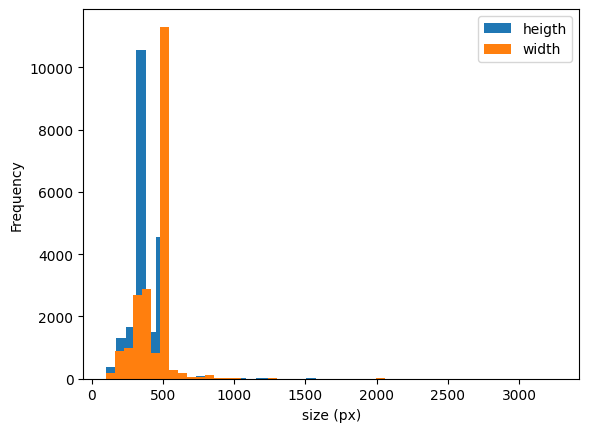

Larguer et hauteur moyennes par image :  (385.86, 442.53)


In [12]:
ds_img['heigth'].plot.hist(bins=35, alpha=1)
ds_img['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()
print("Larguer et hauteur moyennes par image : ", (round(ds_img['heigth'].mean(),2),round(ds_img['width'].mean(),2)))

In [13]:
ds_img['color'].value_counts().values[0]

20579

In [14]:
# Obtenir les fréquences des couleurs dans le DataFrame
color_counts = ds_img['color'].value_counts().reset_index()
color_counts.columns = ['Couleur', 'Fréquence']

# Trier les couleurs par ordre décroissant de fréquence
color_counts = color_counts.sort_values(by='Fréquence', ascending=False)

print("Fréquence des couleurs dans le dataset :")
print(color_counts)

Fréquence des couleurs dans le dataset :
   Couleur  Fréquence
0        3      20579
1        4          1


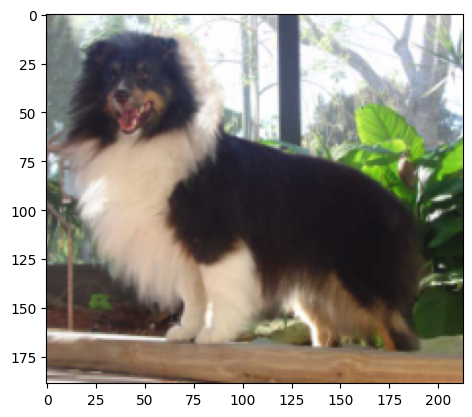

In [15]:
image_color_4 = ds_img[ds_img.color==4].index[0]
img4 = mpimg.imread(image_color_4)
plt.imshow(img4)

L'indice de couleur exprime en fait le niveau de transparence de l'image. Une seule est à 4, on remarque que c'est une image avec une transparence forte dans la partie supérieure droite.

(-0.5, 499.5, 324.5, -0.5)

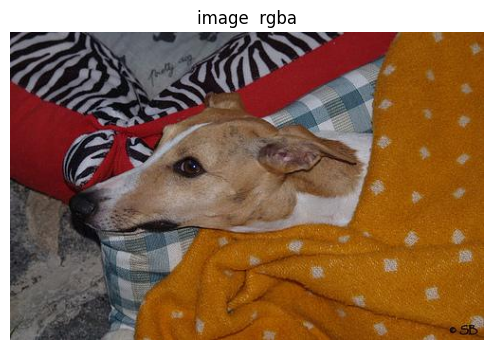

In [16]:
#Affichage d'une image au hasard
plt.fig = plt.figure(figsize=(10,4))
idx = ds_img[ds_img.color==3].index[random.randint(0,len(ds_img[ds_img.color==3]))]
img4 = mpimg.imread(idx)
plt.imshow(img4)
plt.title("image  rgba")
plt.axis('off')

Regardons quelques exemples des images par races disponibles dans notre base d'étude :

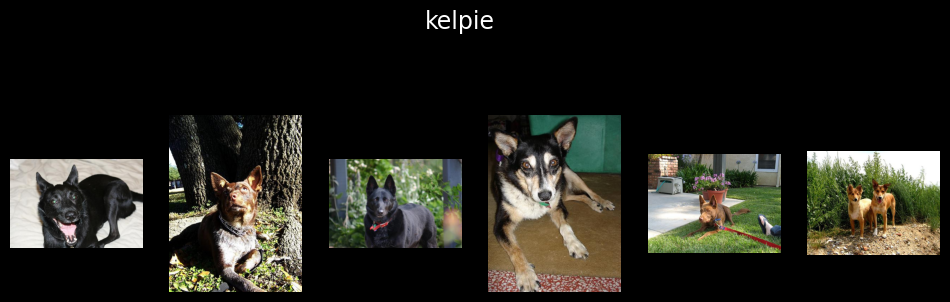

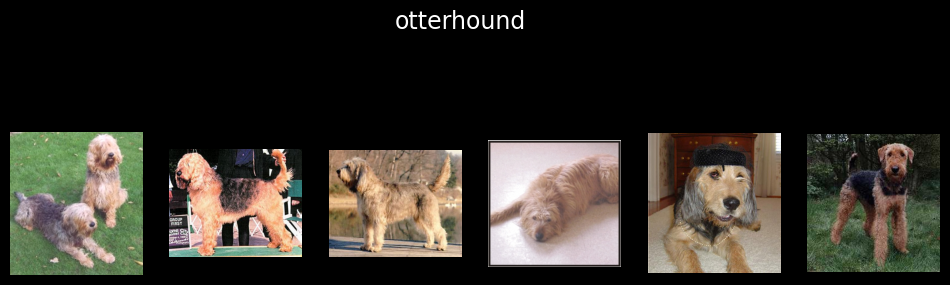

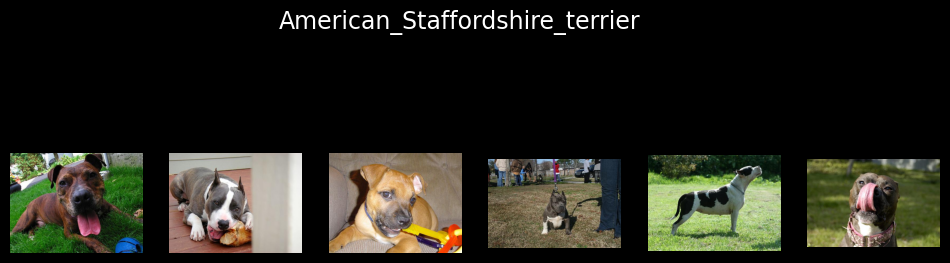

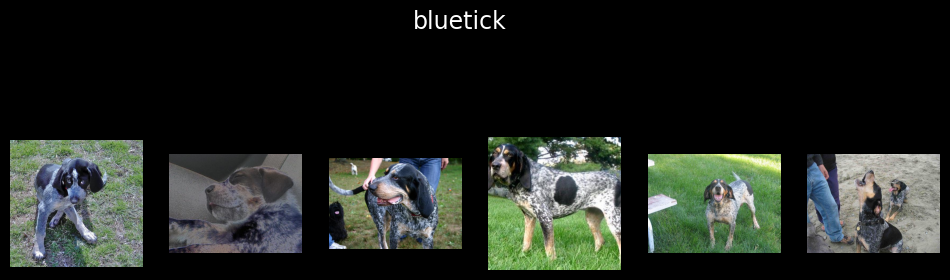

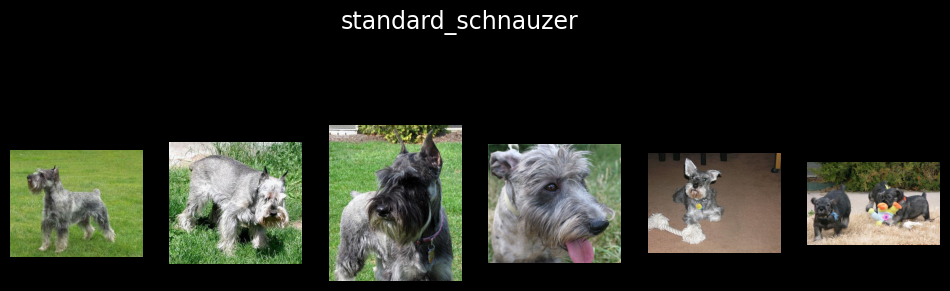

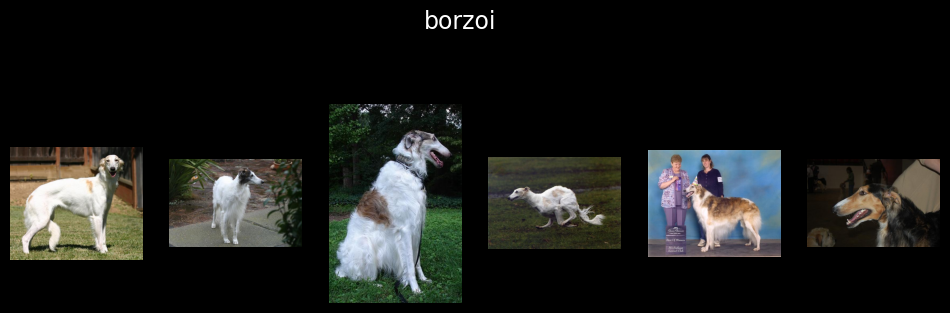

In [17]:
plt.style.use('dark_background')

Num = 6
breed_id_sample = np.random.choice(df['Id_name_breed'].values,Num)
for classe in breed_id_sample:
   images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)[:Num]
   fig = plt.figure(figsize=(12,4))
   plt.suptitle("{}".format(classe.split("-")[1]), color="w", fontsize=17) 
   for i in range(Num):
        img = mpimg.imread(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        plt.subplot(1, Num, i+1)
        plt.imshow(img)
        plt.axis('off')  
   plt.show()

La dimension des images n'est pas uniforme ; or le modèle CNN exige une taille unique pour toutes les données. Il faut donc redimensionner les images à une dimension unique. Nous choisissons la dimenstion standard 300*300.

Nous allons ainsi effectuer un ensemble de transformation sur notre base des images. Notamment, la redimensinnement, l'égalisation, le débruitage et le blanchiment.

## 3. Preprocessing

### 1.2.1 Egalisation d'histogramme

Il s'agit de mieux répartir l'intensité lumineuse dans l'ensemble de l'image : les images ternes seront éclairées, les images claires seront assombries.  Cela revient à égaliser un histogramme.  
  
![Histogramme](https://docs.opencv.org/4.x/histogram_equalization.png)  
  
Pour des images couleur, il faut procéder couleur par couleur : red, green, puis blue.

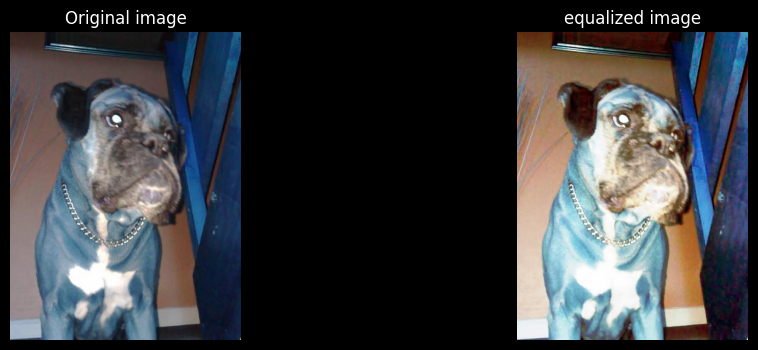

In [18]:
random_path = ds_img.index[np.random.randint(len(ds_img))]
image = cv2.imread(random_path)

# Equalization
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# Show both images
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("equalized image")
plt.show()           

### 1.2.2 Débruitage de l'image

Une image peut être "bruitée", c-à-d avoir des pixels indésirables, du grain, en raison de la mauvaise qualité de l'appareil ou de conditions climatiques défavorables.  
Pour débruiter, OpenCV calcule les moyennes de blocs de pixels similaires (blocs avec les mêmes variations de couleur, les mêmes motifs...) et corrgie ensuite chaque bloc individuel. Cela homogénéise, enlève les détails spécifiques de chaque bloc mais limite aussi les "erreurs" du bruit.

Pour la méthode "fastNlMeansDenoisingColored", j'utilise des paramètres par défaut, retrouvés dans différentes explications sur le sujet, notamment sur la documentation [https://docs.opencv.org/4.x/d1/d79/group__photo__denoise.html].

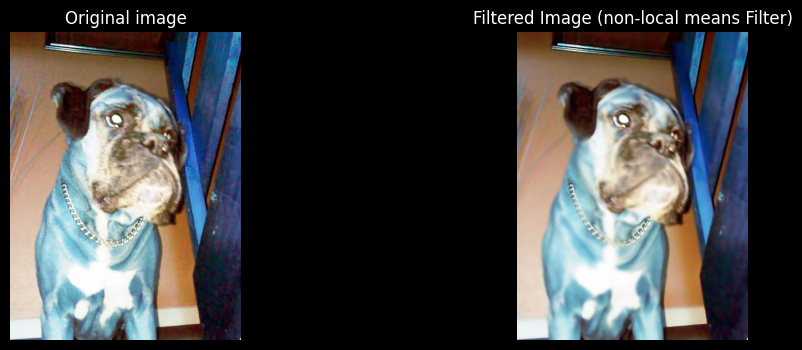

In [19]:
# Apply non-local means filter on test img
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,21,7)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(img_nlf)
plt.title("Filtered Image (non-local means Filter)")
plt.show()

### 1.2.3 Whitening

Le but du whitening est de supprimer la corrélation entre les pixels.  
Le whitening, contrairement à ce que son nom indique, n'aboutit pas forcément à une image en noir et blanc.

Le processus de whitening peut être résumé comme suit :

Calcul de la matrice de covariance : Tout d'abord, on calcule la matrice de covariance à partir des données d'entrée. La matrice de covariance représente les relations statistiques entre les différentes caractéristiques de l'ensemble de données.

Décomposition en valeurs propres et vecteurs propres : Ensuite, on effectue une décomposition en valeurs propres et vecteurs propres de la matrice de covariance. Cela permet de déterminer les directions principales (vecteurs propres) le long desquelles les données sont les plus étendues et les valeurs propres indiquent les variances associées à ces directions.

Normalisation des vecteurs propres : Les vecteurs propres sont normalisés pour avoir une longueur unitaire, ce qui permet d'obtenir une base orthonormée.

Réduction de la corrélation : Les données d'entrée sont projetées sur cette nouvelle base orthonormée, ce qui les rend décorrélées. Cela signifie que les nouvelles caractéristiques sont statistiquement indépendantes les unes des autres.

Ajustement de l'échelle : Enfin, les caractéristiques sont ajustées en échelle pour avoir une variance unitaire, ce qui est également appelé mise à l'échelle unitaire.

In [20]:
# Test ChatGPT

In [21]:
def whitening(image):
    # Convert the image to floating-point type and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Calculate the covariance matrix of the image channels
    cov_matrix = np.cov(image.reshape(-1, 3), rowvar=False)

    # Perform the eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors in decreasing order of eigenvalues
    order = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, order]

    # Whitening transformation: Xwhitened = (X - mean) * V * D^(-1/2)
    mean = np.mean(image, axis=(0, 1))
    whitened_image = np.dot(image - mean, eigenvectors) / np.sqrt(eigenvalues + 1e-5)

    # Scale the whitened image to the range [0, 255]
    whitened_image = (whitened_image - np.min(whitened_image)) / (np.max(whitened_image) - np.min(whitened_image))
    whitened_image = (whitened_image * 255).astype(np.uint8)

    return whitened_image

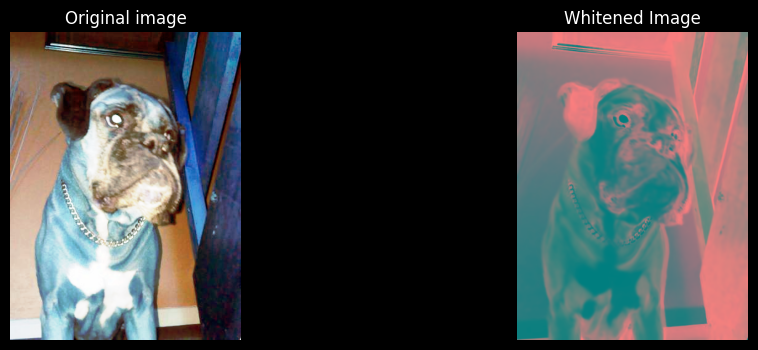

In [22]:
whitened_image = whitening(img_nlf)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(whitened_image,cmap='Greys')
plt.title("Whitened Image")
plt.show()

### 1.2.4 Augmentation de données

L'objectif est de produire de nouvelles images depuis des images existantes afiin d'augmenter la base de données.  
Il s'agit d'appliquer des transformations géométriques aléatoires : translations, rotations, mirroring, ...

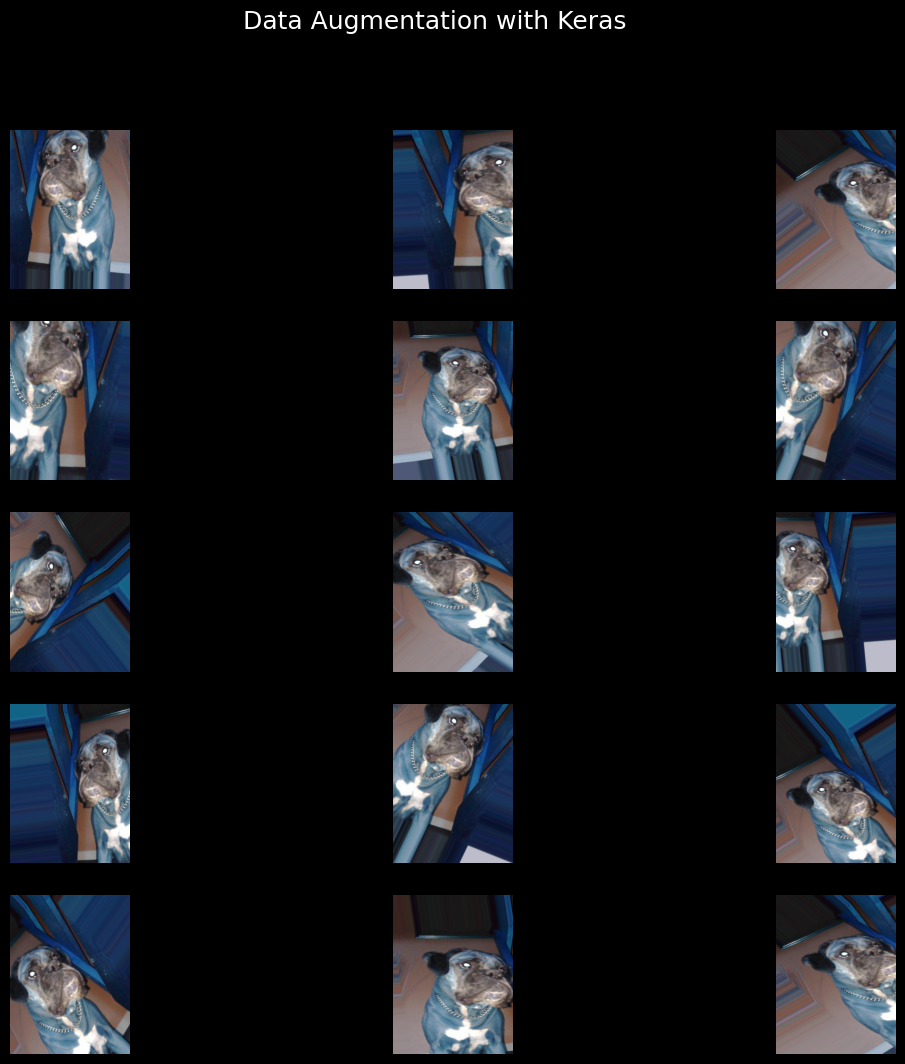

In [23]:
# Création du générateur d'images
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert an image to array
x = image.reshape((1,) + image.shape)

# Generate batches of augmented images from `x`
fig = plt.figure(figsize=(14,12))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):

    # We only want the first 15 batches, so break the loop after that
    if i == 15:
        break

    # Get the subplot for the current batch and display it
    ax = fig.add_subplot(5, 3, i+1)
    ax.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))

    plt.axis('off') 


plt.suptitle("Data Augmentation with Keras", fontsize=18)
plt.show()

## 4. Modèles CNN

Plusieurs paramètres doivent être définis pour entrainer un modèle CNN : 
- __le type de fonction d'activation__ : elle introduit de la non-linéarité dans le modèle et détermine l'output d'un neurone dans le réseau
- __l'algorithme d'optimisation__ : méthode utilisée pour ajuster les poids du réseau afin de minimiser la fonction de coût
- __le nb de filtres__ (sur la couche de convolution)/nb de kernel : chaque filtre est capable de détecter une caractéristique spécifique dans l'image (par exemple, les bords, les couleurs, etc.). Un nombre plus élevé de filtres permet au réseau d'apprendre une plus grande variété de caractéristiques, mais augmente également la complexité du modèle.
- __le Wind__ : taille de la fenêtre d'entrée sur laquelle le filtre de convolution est appliqué. Par exemple, une taille de fenêtre de 3 signifie que le filtre est appliqué sur des carrés de 3x3 pixels à la fois. La taille de la fenêtre influence le niveau de détail que le réseau peut apprendre : une taille de fenêtre plus petite permet de capturer des détails fins, tandis qu'une taille plus grande permet de capturer des caractéristiques plus globales.
- __le nb d'Epochs__ : nb de fois l'ensemble du jeu de données est passé au travers du réseau neuronal

Il va falloir déterminer quels sont les paramètres les plus performants dans notre cas.

Les mesures classiques d'évaluation d'un modèle CNN sont :
- __Accuracy__ : indique la performance du modèle à travers la proportion d'observations correctement classées par rapport à toutes les observations
- __Loss__ : mesure la manière dont le modèle s'ajuste aux données. Une perte élevée indique un surajustement, une perte faible est bon signe.

### Train-test sur 5 races

In [24]:
NB_BREEDS = 5

In [25]:
def preprocessing(uri_list,input_shape):
    """Preprocessing of images for convolutional neural network.
    Equalization, Denoising and transformation of the image into Array. 
    ------------------
    param:
    uri_list: 
    list of images directories
    input_shape: 
    (width, heigth) size of the image  for target resizing
    """
    img_list=[]
    for uri in uri_list:
            # Read image
            image = cv2.imread(uri)
            # Resize image
            image = cv2.resize(image, input_shape)
            # Equalization
            r_image, g_image, b_image = cv2.split(image)
            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)
            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            # Apply non-local means filter 
            img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
            img_nlf = whitening(img_nlf)
            # Append lists of labels and image
            img_list.append(img_nlf)
            #labels = ds_img.bread_name[0:tot_nb_img]
        
  
    return np.array(img_list)

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [27]:
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X = preprocessing(uri_list, (224,224))
y = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y = np.array(y)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

CHANGER 300, 300 en 224, 224

In [28]:
from tensorflow.keras.utils import to_categorical

In [29]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded = to_categorical(y_train, num_classes=NB_BREEDS)
y_test_encoded = to_categorical(y_test, num_classes=NB_BREEDS)

In [30]:
# Shape des images
X[0].shape # is the first image

(224, 224, 3)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

### Callbacks

In [32]:
import keras

In [33]:
checkpoint_cb  = keras.callbacks.ModelCheckpoint("Best_Model_1.h5",monitor='loss',
                                                 verbose=1,save_best_only=True,mode='min')

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,
                                                  patience=10,verbose=1,mode='auto')

In [35]:
callbacks = [checkpoint_cb, early_stopping_cb]

In [36]:
def create_model(NB_BREEDS):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(NB_BREEDS, activation='softmax')) # For multi-class classification
    
    
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Modèle bis qui copie un peu le VGG16  
Accuracy comme métrique d'évaluation  
Optimizer : Adam ; on aurait aussi pu utiliser RMSProp, qui utilise aussi la descente de gradient. 
Ce qui est intéressant dans un optimizer c'est le learning rate ; il faut bien le choisir pour éviter l'overfitting ; si petit : résultats tb mais overfittés
Mais on peut rajouter une couche de DropOut pour éviter l'overfitting justement.

DEFINIR L'OPTIMIZER DANS LA FONCTION, à côté de NB_BREEDS

LANCER LA FONCTION DE DAOUDA, DANS NBK SUR MAIL

In [37]:
from keras.layers import Dropout

In [38]:
def create_model_bis(NB_BREEDS):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(NB_BREEDS, activation='softmax')) # For multi-class classification
                    # Couche Dropout : permet de prévenir le surapprentissage
    
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Pb de surapprentissage : corrections de Daouda : 
- Commentaire de lignes Convolutionnel et Pooling.
- Changement d'optimizer de adam vers sgd

MAIS du coup l'accuracy ne change plus, sur > 10 epochs.

In [39]:
model = create_model(NB_BREEDS)
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), batch_size=32, callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 24549616478799170258773999616.0000 - accuracy: 0.2105
Epoch 1: loss improved from inf to 24549616478799170258773999616.00000, saving model to Best_Model_1.h5


/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 12s 471ms/step - loss: 24549616478799170258773999616.0000 - accuracy: 0.2105 - val_loss: 1.6091 - val_accuracy: 0.1398
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 1.6092 - accuracy: 0.2146
Epoch 2: loss improved from 24549616478799170258773999616.00000 to 1.60921, saving model to Best_Model_1.h5
24/24 [==============================] - 10s 435ms/step - loss: 1.6092 - accuracy: 0.2146 - val_loss: 1.6075 - val_accuracy: 0.3065
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.2362
Epoch 3: loss improved from 1.60921 to 1.60866, saving model to Best_Model_1.h5
24/24 [==============================] - 10s 420ms/step - loss: 1.6087 - accuracy: 0.2362 - val_loss: 1.6062 - val_accuracy: 0.3065
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 1.6082 - accuracy: 0.2362
Epoch 4: loss improved from 1.60866 to 1.60825, saving model to Best_Model_1.h5
24/24 [================

Il faut bcp de temps pour optimiser ces modèles, à la main, en améliorant la suite des couches. C'est pour cela aussi qu'on peut se tourner vers le Transfer Learning, qui va bien plus loin.

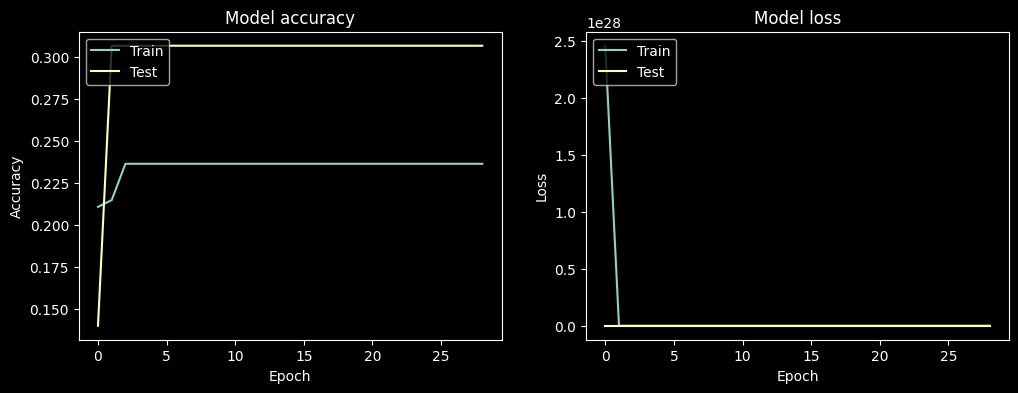

In [40]:
def plot_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_results(history)

In [ ]:
# Test

In [85]:
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X = preprocessing(uri_list, (224,224))/255 # On divise par 255 pour faire une sorte de StandardScaler
y = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y = np.array(y)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [ ]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded = to_categorical(y_train, num_classes=NB_BREEDS)
y_test_encoded = to_categorical(y_test, num_classes=NB_BREEDS)

In [ ]:
model = create_model(NB_BREEDS)
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), batch_size=32, callbacks=callbacks)

In [ ]:
plot_results(history)

In [ ]:
# Fin test

### Train-test sur 15 races

In [41]:
NB_BREEDS = 15

In [42]:
uri_list_2 =ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X_2 = preprocessing(uri_list_2, (224,224))
y_2 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_2 = np.array(y_2)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_2 = LabelEncoder()
encoder_2.fit(y_2)
y_2 = encoder_2.transform(y_2)

In [43]:
#Séparation jeux entraînement/test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_2 = to_categorical(y_train_2, num_classes=NB_BREEDS)
y_test_encoded_2 = to_categorical(y_test_2, num_classes=NB_BREEDS)

In [44]:
model_2 = create_model(NB_BREEDS)
history_2 = model_2.fit(X_train_2, y_train_encoded_2, epochs=10, validation_data=(X_test_2, y_test_encoded_2))

Epoch 1/10
64/64 [==============================] - 25s 392ms/step - loss: 25807.5293 - accuracy: 0.0815 - val_loss: 2.7104 - val_accuracy: 0.0902
Epoch 2/10
64/64 [==============================] - 27s 421ms/step - loss: 2.7058 - accuracy: 0.0893 - val_loss: 2.7128 - val_accuracy: 0.0686
Epoch 3/10
64/64 [==============================] - 25s 394ms/step - loss: 2.7058 - accuracy: 0.0849 - val_loss: 2.7082 - val_accuracy: 0.0725
Epoch 4/10
64/64 [==============================] - 23s 361ms/step - loss: 2.7043 - accuracy: 0.0879 - val_loss: 2.7067 - val_accuracy: 0.0902
Epoch 5/10
64/64 [==============================] - 22s 349ms/step - loss: 2.7044 - accuracy: 0.0893 - val_loss: 2.7110 - val_accuracy: 0.0902
Epoch 6/10
64/64 [==============================] - 22s 346ms/step - loss: 2.7042 - accuracy: 0.0903 - val_loss: 2.7094 - val_accuracy: 0.0902
Epoch 7/10
64/64 [==============================] - 21s 332ms/step - loss: 2.7038 - accuracy: 0.0913 - val_loss: 2.7107 - val_accuracy: 0.

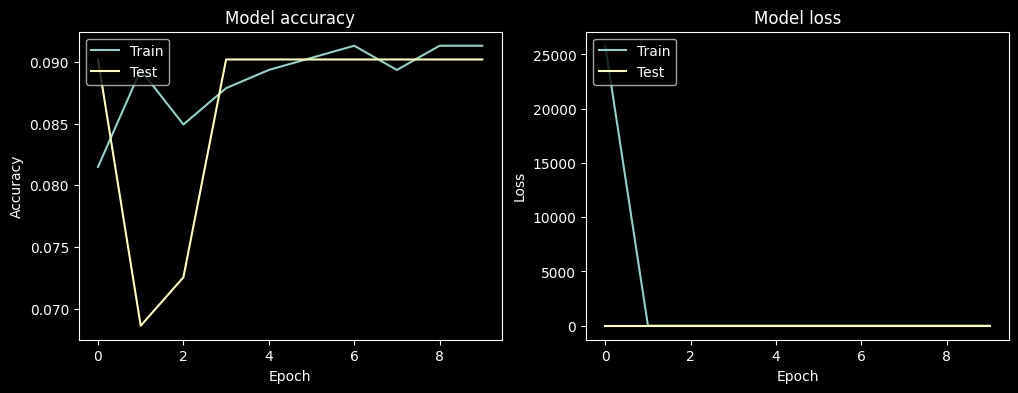

In [45]:
plot_results(history_2)

### Data Augmentation sur 5 races

In [46]:
NB_BREEDS = 5

In [47]:
uri_list_15_3 = ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
X_3 = preprocessing(uri_list_15_3, (224,224))
y_3 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_3 = np.array(y_3)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_3 = LabelEncoder()
encoder_3.fit(y_3)
y_3 = encoder_3.transform(y_3)

In [48]:
#Séparation jeux entraînement/test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_3 = to_categorical(y_train_3, num_classes=NB_BREEDS)
y_test_encoded_3 = to_categorical(y_test_3, num_classes=NB_BREEDS)

Observer cb d'images sont créées ; comment le Data Augmentation se passe (transformationd es images existantes et/ou création de nouvelles)

In [49]:
model_3 = create_model(NB_BREEDS)

In [50]:
train_gen2 = datagen.flow(X_train_3, y_train_encoded_3, batch_size=32)

In [51]:
history_3 = model_3.fit(train_gen2, epochs=10, validation_data=(X_test_3, y_test_encoded_3))

Epoch 1/10
24/24 [==============================] - 10s 376ms/step - loss: 1.6369 - accuracy: 0.2281 - val_loss: 68.5389 - val_accuracy: 0.3011
Epoch 2/10
24/24 [==============================] - 10s 424ms/step - loss: 1.5987 - accuracy: 0.2807 - val_loss: 80.8580 - val_accuracy: 0.3118
Epoch 3/10
24/24 [==============================] - 9s 381ms/step - loss: 1.5635 - accuracy: 0.2888 - val_loss: 94.6547 - val_accuracy: 0.3548
Epoch 4/10
24/24 [==============================] - 9s 381ms/step - loss: 1.5650 - accuracy: 0.2753 - val_loss: 74.8325 - val_accuracy: 0.3280
Epoch 5/10
24/24 [==============================] - 9s 384ms/step - loss: 1.5482 - accuracy: 0.2780 - val_loss: 71.5457 - val_accuracy: 0.3011
Epoch 6/10
24/24 [==============================] - 11s 439ms/step - loss: 1.5453 - accuracy: 0.2794 - val_loss: 75.4264 - val_accuracy: 0.3226
Epoch 7/10
24/24 [==============================] - 10s 398ms/step - loss: 1.5377 - accuracy: 0.2969 - val_loss: 82.4202 - val_accuracy: 0.

Impossible de savoir cb de fois le modèle va voir les images originales et cb de fois il va voir les images data augmentées.

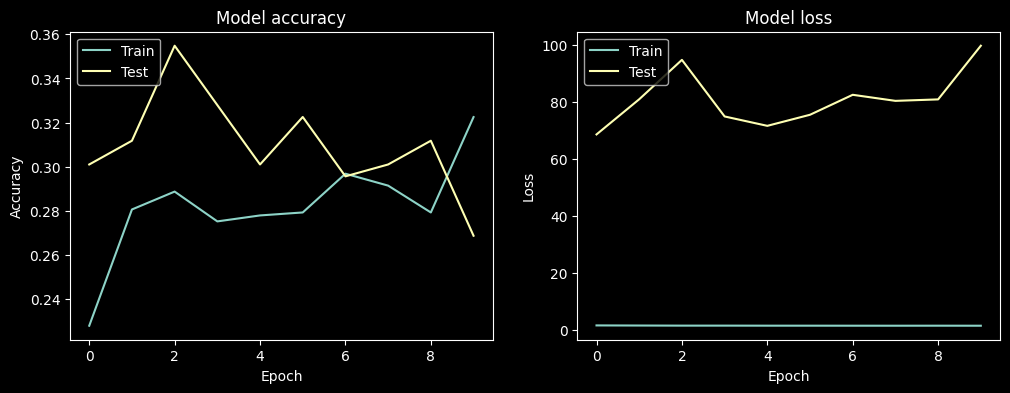

In [52]:
plot_results(history_3)

La Data Augmentation a-t-elle apporté une meilleure accuracy et un meilleur loss ?

In [53]:
# End code

Ces approches ont leurs limites : on teste donc le Transfer Learning

## 5. Transfer Learning

Documentation sur les différents modèles : https://keras.io/api/applications/xception/

### VGG16

Modèle facile à comprendre avec des couches similaires les unes aux autres.  
Inconvénients : lenteur et demande des ressources importantes.

In [54]:
NB_BREEDS = 15
uri_list_vgg16 = ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

X_vgg16 = preprocessing(uri_list_vgg16, (224,224))
y_vgg16 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_vgg16 = np.array(y_vgg16)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_vgg16 = LabelEncoder()
encoder_vgg16.fit(y_vgg16)
y_vgg16 = encoder_vgg16.transform(y_vgg16)

#Séparation jeux entraînement/test
X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(X_vgg16, y_vgg16, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_vgg16 = to_categorical(y_train_vgg16, num_classes=NB_BREEDS)
y_test_encoded_vgg16 = to_categorical(y_test_vgg16, num_classes=NB_BREEDS)

In [55]:
from keras.applications.vgg16 import preprocess_input

train_datagen_vgg16 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function= preprocess_input)

test_datagen_vgg16 = ImageDataGenerator(preprocessing_function=preprocess_input)

In [56]:
y_train_encoded_vgg16.shape

(2037, 15)

In [57]:
train_gen_vgg16 = train_datagen_vgg16.flow(X_train_vgg16, y_train_encoded_vgg16, batch_size=32, subset="training")
validation_vgg16 = train_datagen_vgg16.flow(X_train_vgg16, y_train_encoded_vgg16, batch_size=32, subset='validation')

In [58]:
from keras.applications.vgg16 import VGG16
# load model and specify a new input shape for images
model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [59]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(NB_BREEDS, activation='softmax'))

In [ ]:
# Test Daouda amélioration modèle

In [109]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NB_BREEDS, activation='softmax')(x)# nb output visé (ici 7 catégories)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [97]:
from tensorflow.keras.callbacks import ModelCheckpoint,  EarlyStopping

In [110]:
model2 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [111]:
# Entraîner sur les données d'entraînement (X_train, y_train)
history1 = model2.fit(X_train_vgg16, y_train_encoded_vgg16, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_test_vgg16, y_test_encoded_vgg16), verbose=1)

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 3.8373 - accuracy: 0.1070
Epoch 1: val_loss improved from inf to 2.59126, saving model to ./model1_best_weights.h5
32/32 [==============================] - 286s 9s/step - loss: 3.8373 - accuracy: 0.1070 - val_loss: 2.5913 - val_accuracy: 0.1549
Epoch 2/50


/Users/alexandremonod/Python/OC_ML/projet_6_classer_des_images/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 2.5908 - accuracy: 0.1772
Epoch 2: val_loss improved from 2.59126 to 2.52234, saving model to ./model1_best_weights.h5
32/32 [==============================] - 276s 9s/step - loss: 2.5908 - accuracy: 0.1772 - val_loss: 2.5223 - val_accuracy: 0.1882
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.4171 - accuracy: 0.2150
Epoch 3: val_loss improved from 2.52234 to 2.37370, saving model to ./model1_best_weights.h5
32/32 [==============================] - 272s 9s/step - loss: 2.4171 - accuracy: 0.2150 - val_loss: 2.3737 - val_accuracy: 0.2569
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.2515 - accuracy: 0.2744
Epoch 4: val_loss improved from 2.37370 to 2.29990, saving model to ./model1_best_weights.h5
32/32 [==============================] - 256s 8s/step - loss: 2.2515 - accuracy: 0.2744 - val_loss: 2.2999 - val_accuracy: 0.2627
Epoch 5/50
32/32 [==============================] - ETA: 0s 

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 15)                376335    
                                                                 
Total params: 15091023 (57.57 MB)
Trainable params: 15091023 (57.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
from tensorflow.keras.optimizers import Adam

In [62]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [63]:
train_gen_vgg16

DAOUDA me dit qu'il y a un pb dans mes données : qch à 160 dans mes données est en conflit avec les 15 de NB_BREEDS.

In [64]:
import math

In [81]:
math.ceil(len(X_train) / 32)

24

In [65]:
# Fit and results
result_vgg16 = model.fit(train_gen_vgg16,
          validation_data=validation_vgg16,
          steps_per_epoch=math.ceil(len(X_train) / 32), epochs=30, verbose=2)

Epoch 1/30
24/24 - 283s - loss: 3.3835 - accuracy: 0.0690 - val_loss: 2.7120 - val_accuracy: 0.0786 - 283s/epoch - 12s/step
Epoch 2/30
24/24 - 279s - loss: 2.7112 - accuracy: 0.0770 - val_loss: 2.7067 - val_accuracy: 0.0860 - 279s/epoch - 12s/step
Epoch 3/30
24/24 - 278s - loss: 2.7070 - accuracy: 0.0888 - val_loss: 2.7060 - val_accuracy: 0.0835 - 278s/epoch - 12s/step
Epoch 4/30
24/24 - 276s - loss: 2.7095 - accuracy: 0.0679 - val_loss: 2.7065 - val_accuracy: 0.0614 - 276s/epoch - 12s/step
Epoch 5/30
24/24 - 281s - loss: 2.7071 - accuracy: 0.0770 - val_loss: 2.7084 - val_accuracy: 0.0565 - 281s/epoch - 12s/step
Epoch 6/30
24/24 - 281s - loss: 2.7131 - accuracy: 0.0692 - val_loss: 2.7058 - val_accuracy: 0.0614 - 281s/epoch - 12s/step
Epoch 7/30
24/24 - 282s - loss: 2.7469 - accuracy: 0.0587 - val_loss: 2.7082 - val_accuracy: 0.0786 - 282s/epoch - 12s/step
Epoch 8/30
24/24 - 281s - loss: 2.7132 - accuracy: 0.0627 - val_loss: 2.7148 - val_accuracy: 0.0614 - 281s/epoch - 12s/step
Epoch 9/

In [ ]:
# Test

In [ ]:
NB_BREEDS = 15
uri_list_vgg16 = ds_img.index.values[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

X_vgg16 = preprocessing(uri_list_vgg16, (224,224))
y_vgg16 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]

# Convert data in numpy array
y_vgg16 = np.array(y_vgg16)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder_vgg16 = LabelEncoder()
encoder_vgg16.fit(y_vgg16)
y_vgg16 = encoder_vgg16.transform(y_vgg16)

#Séparation jeux entraînement/test
X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(X_vgg16, y_vgg16, test_size=0.2,shuffle=True, random_state=42)

# Passage des X et y de int en categ
y_train_encoded_vgg16 = to_categorical(y_train_vgg16, num_classes=NB_BREEDS)
y_test_encoded_vgg16 = to_categorical(y_test_vgg16, num_classes=NB_BREEDS)

In [ ]:
from keras.applications.vgg16 import preprocess_input

train_datagen_vgg16 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function= preprocess_input)

test_datagen_vgg16 = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
y_train_encoded_vgg16.shape

(2037, 15)

In [ ]:
train_gen_vgg16 = train_datagen_vgg16.flow(X_train_vgg16, y_train_encoded_vgg16, batch_size=32, subset="training")
validation_vgg16 = train_datagen_vgg16.flow(X_train_vgg16, y_train_encoded_vgg16, batch_size=32, subset='validation')

In [ ]:
from keras.applications.vgg16 import VGG16
# load model and specify a new input shape for images
model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

In [ ]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(NB_BREEDS, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 15)                376335    
                                                                 
Total params: 15091023 (57.57 MB)
Trainable params: 15091023 (57.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
train_gen_vgg16

DAOUDA me dit qu'il y a un pb dans mes données : qch à 160 dans mes données est en conflit avec les 15 de NB_BREEDS.

In [ ]:
import math

In [ ]:
math.ceil(len(X_train) / 32)

24

In [ ]:
# Fit and results
result_vgg16 = model.fit(train_gen_vgg16,
          validation_data=validation_vgg16,
          steps_per_epoch=math.ceil(len(X_train) / 32), epochs=30, verbose=2)

Epoch 1/30
24/24 - 283s - loss: 3.3835 - accuracy: 0.0690 - val_loss: 2.7120 - val_accuracy: 0.0786 - 283s/epoch - 12s/step
Epoch 2/30
24/24 - 279s - loss: 2.7112 - accuracy: 0.0770 - val_loss: 2.7067 - val_accuracy: 0.0860 - 279s/epoch - 12s/step
Epoch 3/30
24/24 - 278s - loss: 2.7070 - accuracy: 0.0888 - val_loss: 2.7060 - val_accuracy: 0.0835 - 278s/epoch - 12s/step
Epoch 4/30
24/24 - 276s - loss: 2.7095 - accuracy: 0.0679 - val_loss: 2.7065 - val_accuracy: 0.0614 - 276s/epoch - 12s/step
Epoch 5/30
24/24 - 281s - loss: 2.7071 - accuracy: 0.0770 - val_loss: 2.7084 - val_accuracy: 0.0565 - 281s/epoch - 12s/step
Epoch 6/30
24/24 - 281s - loss: 2.7131 - accuracy: 0.0692 - val_loss: 2.7058 - val_accuracy: 0.0614 - 281s/epoch - 12s/step
Epoch 7/30
24/24 - 282s - loss: 2.7469 - accuracy: 0.0587 - val_loss: 2.7082 - val_accuracy: 0.0786 - 282s/epoch - 12s/step
Epoch 8/30
24/24 - 281s - loss: 2.7132 - accuracy: 0.0627 - val_loss: 2.7148 - val_accuracy: 0.0614 - 281s/epoch - 12s/step
Epoch 9/

In [ ]:
#Fin test

### Inception

L'intérêt du Inception est d'éviter le pb de disparition du gradient, commun dans le cas de réseau neurones profonds.  
Il capture des détails à différentes échelles.  
Inconvénient : demande un peu plus de temps de calcul.  
L'input size par défaut de ResNet est 224*224.

In [66]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input


In [67]:
# Preprocessing
X_inception = preprocessing(uri_list_vgg16, (299, 299))  # Seul changement
y_vgg16 = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]


y_inception = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
y_inception = np.array(y_inception)
encoder_inception = LabelEncoder()
encoder_inception.fit(y_inception)
y_inception = encoder_inception.transform(y_inception)
X_train_inception, X_test_inception, y_train_inception, y_test_inception = train_test_split(X_inception, y_inception, test_size=0.2,shuffle=True, random_state=42)
y_train_encoded_inception = to_categorical(y_train_inception, num_classes=NB_BREEDS)
y_test_encoded_inception = to_categorical(y_test_inception, num_classes=NB_BREEDS)

In [68]:
train_datagen_inception = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=inception_preprocess_input)

In [69]:
test_datagen_inception = ImageDataGenerator(preprocessing_function=inception_preprocess_input)

train_gen_inception = train_datagen_inception.flow(X_train_inception, y_train_encoded_inception, batch_size=32, subset="training")
validation_inception = train_datagen_inception.flow(X_train_inception, y_train_encoded_inception, batch_size=32, subset='validation')

In [70]:
# Construction du modèle

model_inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))

model_incep = Sequential()
model_incep.add(model_inception)
model_incep.add(Flatten())
model_incep.add(Dense(NB_BREEDS, activation='softmax'))

87910968/87910968 [==============================] - 4s 0us/step


In [71]:
model_incep.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [72]:
result_incep = model_incep.fit(train_gen_inception,
          validation_data=validation_inception,
          steps_per_epoch=math.ceil(len(X_train_inception) / 32), epochs=30, verbose=2);

Epoch 1/30


64/64 - 289s - loss: 2.4654 - accuracy: 0.3264 - val_loss: 1.9080 - val_accuracy: 0.4398 - 289s/epoch - 5s/step


### ResNet 50

L'intérêt du ResNet est d'éviter le pb de disparition du gradient, commun dans le cas de réseau neurones profonds.  
Il peut "sauter" des connexions entre certains neurones, ce qui lui fait éviter le pb de disparition du gradient
L'input size par défaut de ResNet est 224*224.

In [73]:
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input

In [74]:
# Preprocessing
X_resnet = preprocessing(uri_list_vgg16, (224, 224))

y_resnet = ds_img.breed_name[0:np.sum(df.nb_pic.values[0:NB_BREEDS])]
y_resnet = np.array(y_resnet)
encoder_resnet = LabelEncoder()
encoder_resnet.fit(y_resnet)
y_resnet = encoder_resnet.transform(y_resnet)
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(X_resnet, y_resnet, test_size=0.2,shuffle=True, random_state=42)
y_train_encoded_resnet = to_categorical(y_train_resnet, num_classes=NB_BREEDS)
y_test_encoded_resnet = to_categorical(y_test_resnet, num_classes=NB_BREEDS)

In [75]:
train_datagen_resnet = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=resnet_preprocess_input)

In [76]:
test_datagen_resnet = ImageDataGenerator(preprocessing_function=resnet_preprocess_input)

train_gen_resnet = train_datagen_resnet.flow(X_train_resnet, y_train_encoded_resnet, batch_size=32, subset="training")
validation_resnet = train_datagen_resnet.flow(X_train_resnet, y_train_encoded_resnet, batch_size=32, subset='validation')

In [77]:
model_resnet = ResNet50(include_top=False, input_shape=(224, 224, 3))

model_res = Sequential()
model_res.add(model_resnet)
model_res.add(Flatten())
model_res.add(Dense(NB_BREEDS, activation='softmax'))

model_res.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [79]:
result_res = model_res.fit(train_gen_resnet,
          validation_data=validation_resnet,
          steps_per_epoch=math.ceil(len(X_train_resnet) / 32), epochs=30, verbose=2)

Epoch 1/30


64/64 - 255s - loss: 3.5948 - accuracy: 0.2239 - val_loss: 3.6042 - val_accuracy: 0.2752 - 255s/epoch - 4s/step


In [ ]:
# DAOUDA : LE RANDOMIZEDSEARCH NE PEUT PAR MARCHER ??

__Pour faire tout cela, je crée une fonction avec les couches du modèle, et je lui passe les paramètres avec un RandomizedSearch.__

In [88]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D

In [87]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

ModuleNotFoundError: No module named 'scikeras'

Keras Tuner

In [ ]:
# Fonction pour créer le modèle, nécessaire pour KerasClassifier
def create_model(optimizer='adam', activation='relu', nb_filters=32, kernel_size=3):
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size=(kernel_size, kernel_size), activation=activation, input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(len(list_breeds), activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer le modèle avec KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Définir les paramètres de la grille de recherche
optimizer = ['SGD', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
nb_filters = [32, 64, 128]
kernel_size = [3, 5]
epochs = [10, 20, 30]

param_grid = dict(optimizer=optimizer, activation=activation, nb_filters=nb_filters, kernel_size=kernel_size, epochs=epochs)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring=['accuracy', 'neg_log_loss'], refit='accuracy')

In [ ]:
# ECHEC DU RANDOMIZEDSEARCH

# Fonction pour créer le modèle, nécessaire pour KerasClassifier
def create_model_func(nb_filters, kernel_size):
    def create_model(optimizer='adam', activation='relu'):
        model = Sequential()
        model.add(Conv2D(nb_filters, kernel_size=(kernel_size, kernel_size), activation=activation, input_shape=(64, 64, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation=activation))
        model.add(Dense(len(list_breeds), activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    return create_model


# Créer le modèle avec KerasClassifier
model = KerasClassifier(build_fn=create_model_func(32,3), verbose=0)

# Définir les paramètres de la grille de recherche
optimizer = ['SGD', 'Adam']
activation = ['relu', 'tanh', 'sigmoid']
nb_filters = [32, 64, 128]
kernel_size = [3, 5]
epochs = [10, 20, 30]

param_grid = dict(optimizer=optimizer, activation=activation, nb_filters=nb_filters, kernel_size=kernel_size, epochs=epochs)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, scoring=['accuracy', 'neg_log_loss'], refit='accuracy')

# Exécuter la recherche sur grille
grid_result = grid.fit(X_train, y_train)

# Résumer les résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

ValueError: Invalid parameter nb_filters for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(nb_filters=64)`
Check the list of available parameters with `estimator.get_params().keys()`